In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 
from sklearn import neural_network
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from imblearn.under_sampling import NearMiss

import pickle
import imblearn
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import fbeta_score, make_scorer 
import time
import matplotlib.pyplot as plt
import random
from sklearn import tree

In [ ]:
sfile = pd.read_table(filepath_or_buffer='vispremv.dat', sep=' ', encoding='latin1', index_col=0)
sfile.head()
sfile.info()
df = sfile.copy()
dfDum = pd.get_dummies(df[['SEXEQ', 'FAMIQ', 'PCSPQ']])
dfDum.drop(['SEXEQ_Sfem', 'FAMIQ_Fseu'], axis=1, inplace=True)
dfNum = df.select_dtypes(exclude=['object'])
dfConcat = pd.concat([dfDum, dfNum], axis=1)
y = df['CARVP'].map(lambda x: 0 if x=='Cnon' else 1)
Xnonscale = dfConcat.copy()
#Standardisation
scaler = StandardScaler()
scaler.fit(dfConcat)
X = scaler.transform(dfConcat)

In [6]:
def MakePCA(p_X):
    l_firstpca = PCA()
    l_firstpca.fit(p_X)
    l_cum = np.cumsum(l_firstpca.explained_variance_ratio_)
    l_coude = np.argmax(l_cum > 0.85)
    #print(l_firstpca.explained_variance_ratio_)
    fig, ax1 = plt.subplots()
    l_n = l_firstpca.explained_variance_ratio_.shape[0]
    t = np.arange(0, l_n)
    color = 'tab:red'
    ax1.set_xlabel('nber of component(s)')
    ax1.set_ylabel('cumulative explained variance', color=color)
    ax1.plot(t, np.cumsum(l_firstpca.explained_variance_ratio_), color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('eigen value', color=color)
    ax2.plot(t, l_firstpca.explained_variance_ratio_, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    # Compute the components and projected X
    l_reducingpca = PCA(l_coude).fit(p_X)
    l_150components = l_reducingpca.transform(p_X)
    X_projected = l_reducingpca.inverse_transform(l_150components)
    X_pro = pd.DataFrame(X_projected)
    l_reduced = pd.DataFrame(l_150components)
    return (l_reduced, X_pro, l_coude)

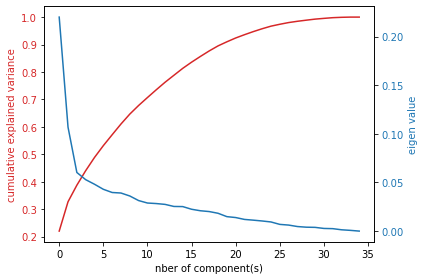

In [8]:
l_tuplenew = MakePCA(X_train_scaled)

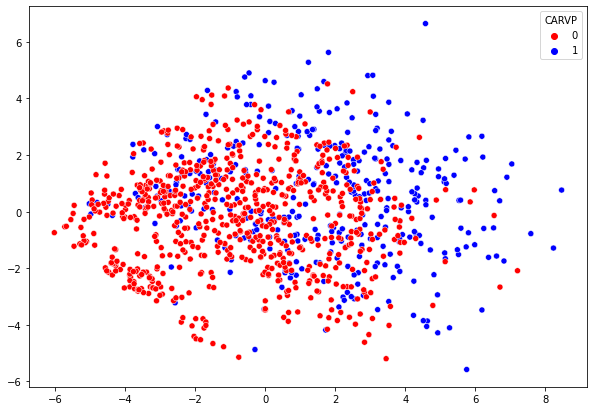

In [9]:
#projection PCA
l_reducingpcaX = PCA(2).fit(X)
l_2componentsX = l_reducingpcaX.transform(X)
X_projected3 = l_reducingpcaX.inverse_transform(l_2componentsX)
X_pro3 = pd.DataFrame(X_projected3)
l_reduced3 = pd.DataFrame(l_2componentsX)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=l_2componentsX[:,0], y=l_2componentsX[:,1],
              data=l_2componentsX, hue=y,
              palette=['red','blue'],
              legend='full')
plt.show()

In [10]:
def ShowOneClassification(p_X, p_y, p_classifier, p_cv):
    X_train, X_test, y_train, y_test = train_test_split(p_X, p_y, test_size=0.2, random_state=25)
    p_classifier.fit(X_train, y_train)
    print("Score sur l'échantillon témoin du classifier")
    #resultats bruts pour un seul test
    l_prediction = p_classifier.predict(X_test)
    l_cm = confusion_matrix(y_test, l_prediction)
    l_score = accuracy_score(y_test, l_prediction)
    l_precision = precision_score(y_test, l_prediction)
    l_recall = recall_score(y_test, l_prediction)
    print(f"First pass Recall / Precision / Accuracy : {l_recall:.4f}, {l_precision:.4f}, {l_score:.4f}")
    if (p_cv>0):
        l_4scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
        l_resultscvs = cross_validate(p_classifier, p_X, p_y, cv=p_cv, scoring=l_4scoring)
        print(f"Recall Average : {np.mean(l_resultscvs['test_recall']):.4f}")
        #l_crossprecision = cross_val_score(l_classifier, X_train, y_train, cv=p_cv, scoring='precision')
        print(f"Precision Average : {np.mean(l_resultscvs['test_precision']):.4f}")
        #l_score = cross_val_score(l_classifier, X_train, y_train, cv=p_cv)
        print(f"Score Averag : {np.mean(l_resultscvs['test_accuracy']):.4f}")
        print(f"F1-Score Averag : {np.mean(l_resultscvs['test_f1_score']):.4f}")
    # ROC curve
    y_pred = [x[1] for x in p_classifier.predict_proba(X_test)]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    plt.figure(1, figsize = (5, 5))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    #plt.show()
    # PR curve
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.figure(1, figsize = (5, 5))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plot_confusion_matrix(p_classifier, X_test, y_test)
    plt.show()

In [11]:
def TestOneClassifier(p_classifier, p_X, p_Y, p_cv, p_gridparams, p_doonetest, p_docrossvalidation):
    if (p_doonetest):
        if (p_docrossvalidation):
            l_cv = p_cv
        else:
            l_cv = 0
        ShowOneClassification(p_X, p_Y, p_classifier, l_cv)
    l_gridresult = GridSearchCV(p_classifier, p_gridparams, scoring = 'recall', cv=p_cv, n_jobs=-1)
    l_gridresult.fit(p_X, p_Y)
    l_best_model = l_gridresult.best_estimator_
    #print(l_best_model.get_params())
    ShowOneClassification(p_X, p_Y, l_best_model, l_cv)
    return(l_best_model)    

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6757, 0.8065, 0.8310
Recall Average : 0.7117
Precision Average : 0.7930
Score Averag : 0.8382
F1-Score Averag : 0.7469


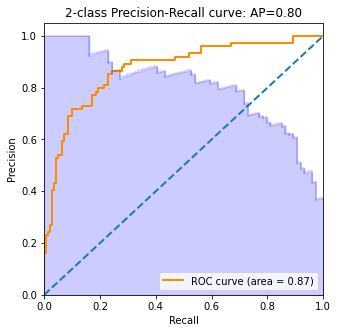

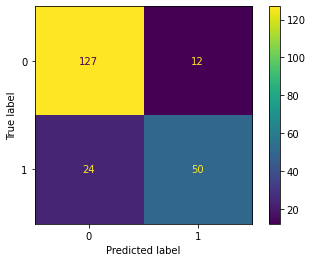

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7297, 0.7500, 0.8216
Recall Average : 0.7227
Precision Average : 0.7346
Score Averag : 0.8175
F1-Score Averag : 0.7260


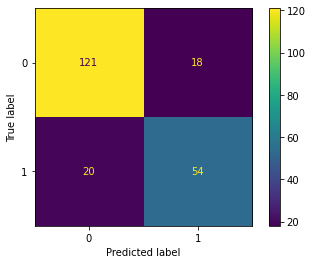

In [207]:
#Logistic Regression
l_classifier = LogisticRegression()
l_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': [ 'l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
l_optimal= TestOneClassifier(l_classifier, X,y, 10, l_param_grid,  True, True)

In [208]:
l_optimal.coef_

array([[ 0.34312911, -0.01504792,  0.2475809 ,  0.06554975,  0.22208536,
        -0.13149526, -0.23221129, -0.22151916,  0.04224803,  0.13176238,
         0.23802759, -0.0278087 , -0.16752522,  0.08003223,  0.17707137,
         0.08273079,  0.15297828,  0.08957129,  0.19344521, -0.04648497,
        -0.15699182,  0.13515903,  0.01395838, -0.0240607 , -0.01755546,
         0.05081992,  0.00556366,  0.0965533 , -0.02219447, -0.05878224,
         0.1369697 , -0.14221028,  0.10224405,  0.14713704,  0.07633566]])

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7973, 0.9219, 0.9061
Recall Average : 0.8225
Precision Average : 0.8620
Score Averag : 0.8934
F1-Score Averag : 0.8250


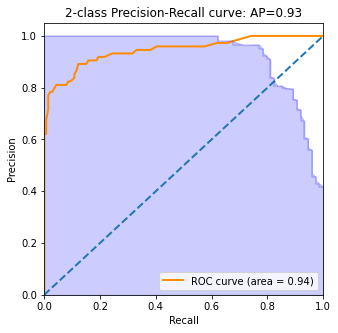

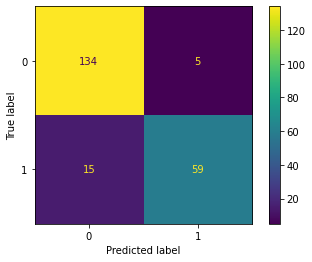

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7838, 0.9062, 0.8967
Recall Average : 0.8442
Precision Average : 0.8755
Score Averag : 0.8980
F1-Score Averag : 0.8410


In [20]:
#RandomForest
l_classifier_RF = RandomForestClassifier(n_estimators=100, random_state=25)
l_param_grid_RF = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'n_estimators' : [10,100,200]}    
l_optimal_RF= TestOneClassifier(l_classifier_RF, X,y, 100, l_param_grid_RF,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.5000, 0.8043, 0.7840
Recall Average : 0.5430
Precision Average : 0.7326
Score Averag : 0.7799
F1-Score Averag : 0.6217


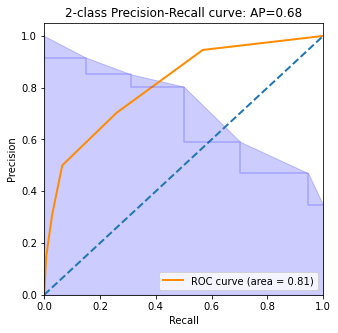

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.4730, 0.5556, 0.6854
Recall Average : 0.5658
Precision Average : 0.6315
Score Averag : 0.7422
F1-Score Averag : 0.5950


In [184]:
#KNN
l_classifier_KNN = KNeighborsClassifier()
l_param_grid_KNN = {
    'n_neighbors': [1, 5, 11, 15, 21, 50, 100], 
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']}
l_optimal_KNN= TestOneClassifier(l_classifier_KNN, X,y, 10, l_param_grid_KNN,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7162, 0.8281, 0.8498
Recall Average : 0.7675
Precision Average : 0.8127
Score Averag : 0.8649
F1-Score Averag : 0.7657


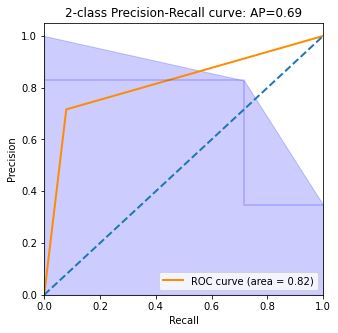

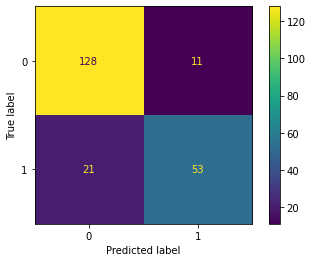

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7162, 0.8154, 0.8451
Recall Average : 0.7950
Precision Average : 0.8435
Score Averag : 0.8837
F1-Score Averag : 0.7927


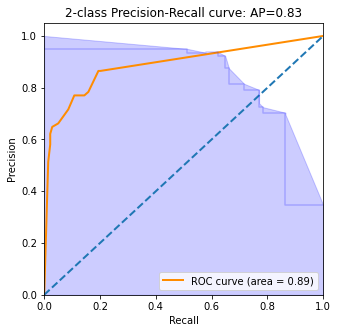

In [187]:
#Decision Tree
l_param_grid_DT = {
    'max_depth': [None, 1, 10, 20, 30], 
    'min_samples_split': [1,2,3,4,5,10,20],
    'min_samples_leaf': [1,2,3,4,5,10,20]
    }
l_classifier_DT = DecisionTreeClassifier()
l_optimal_DT= TestOneClassifier(l_classifier_DT, X,y, 100, l_param_grid_DT,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7703, 0.8769, 0.8826
Recall Average : 0.8275
Precision Average : 0.8488
Score Averag : 0.8991
F1-Score Averag : 0.8205


Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7568, 0.8889, 0.8826
Recall Average : 0.8242
Precision Average : 0.8725
Score Averag : 0.9008
F1-Score Averag : 0.8252


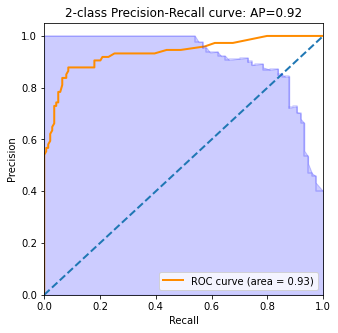

In [21]:
#Bagging
l_classifier_DB = BaggingClassifier(n_estimators=100)
l_param_grid_DB = {'n_estimators': [5, 10, 20, 30, 50,100, 200, 500]}    
l_optimal_DB= TestOneClassifier(l_classifier_DB, X,y, 100, l_param_grid_DB,  True, True)

In [191]:
l_optimal_DB.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7973, 0.9516, 0.9155
Recall Average : 0.8258
Precision Average : 0.8935
Score Averag : 0.9107
F1-Score Averag : 0.8359


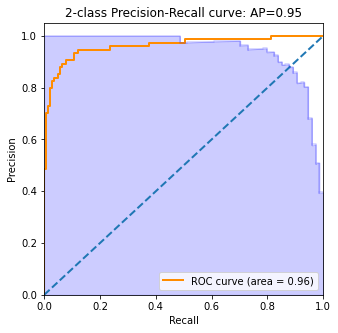

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7973, 0.9516, 0.9155
Recall Average : 0.8117
Precision Average : 0.8898
Score Averag : 0.9080
F1-Score Averag : 0.8260


In [22]:
#Gradient Boosting
l_classifier_GB = GradientBoostingClassifier()
l_param_grid_GB = {
    'n_estimators': [10, 50, 100], # bcp trop long !!! : 1000], 
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 7, 9]
    }
l_optimal_GB= TestOneClassifier(l_classifier_GB, X,y, 100, l_param_grid_GB,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6757, 0.8333, 0.8404
Recall Average : 0.7228
Precision Average : 0.7633
Score Averag : 0.8297
F1-Score Averag : 0.7391


Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6351, 0.7121, 0.7840
Recall Average : 0.7281
Precision Average : 0.7235
Score Averag : 0.8146
F1-Score Averag : 0.7229


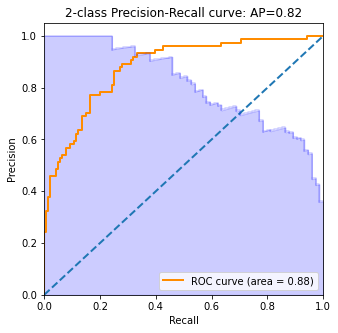

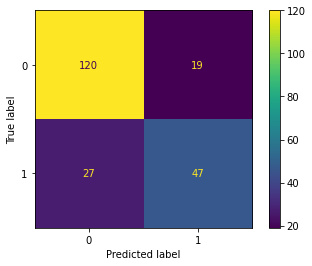

In [195]:
#SVC
l_classifier_SVC = SVC(probability = True)
l_param_grid_SVC = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 5, 11, 15, 21]}
l_optimal_SVC= TestOneClassifier(l_classifier_SVC, X,y, 10, l_param_grid_SVC,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7432, 0.6548, 0.7746
Recall Average : 0.6550
Precision Average : 0.6775
Score Averag : 0.7905
F1-Score Averag : 0.6345


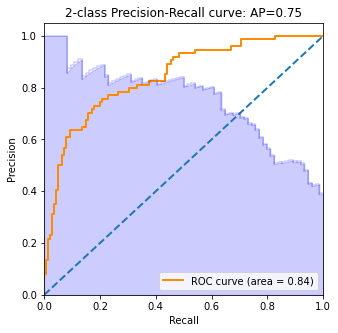

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6351, 0.7121, 0.7840
Recall Average : 0.6525
Precision Average : 0.6700
Score Averag : 0.7783
F1-Score Averag : 0.6255


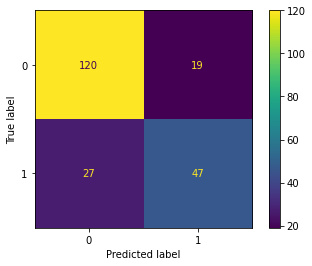

In [197]:
#SGD
l_classifier_SGD = SGDClassifier(loss='log')
l_param_grid_SGD = {'loss': ['log','modified_huber'], 
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}    
l_optimal_SGD= TestOneClassifier(l_classifier_SGD, X,y, 200, l_param_grid_SGD,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.4730, 0.5645, 0.6901
Recall Average : 0.4383
Precision Average : 0.5413
Score Averag : 0.6978
F1-Score Averag : 0.4594


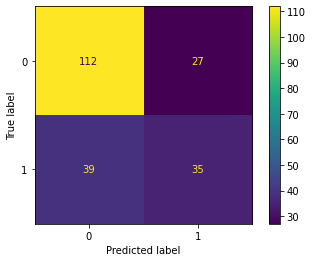

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.4595, 0.5574, 0.6854
Recall Average : 0.4383
Precision Average : 0.5413
Score Averag : 0.6978
F1-Score Averag : 0.4594


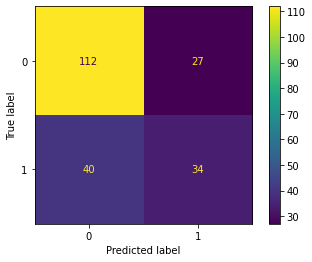

In [221]:
#NaiveBias
Xpos = Xnonscale.copy()
Xpos[Xpos<0]=0
l_classifier_NB = MultinomialNB()
l_param_grid_NB = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0]}    
l_optimal_NB= TestOneClassifier(l_classifier_NB, Xpos,y, 100, l_param_grid_NB,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6216, 0.7667, 0.8028
Recall Average : 0.6357
Precision Average : 0.7233
Score Averag : 0.7893
F1-Score Averag : 0.6693


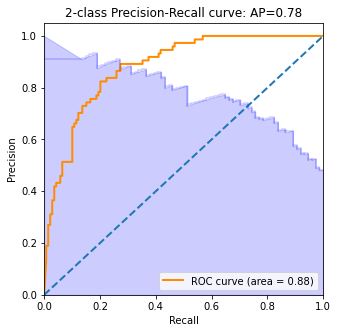

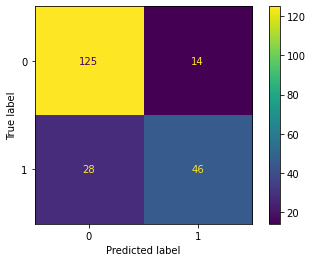

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6351, 0.8246, 0.8263
Recall Average : 0.6163
Precision Average : 0.7426
Score Averag : 0.7959
F1-Score Averag : 0.6689


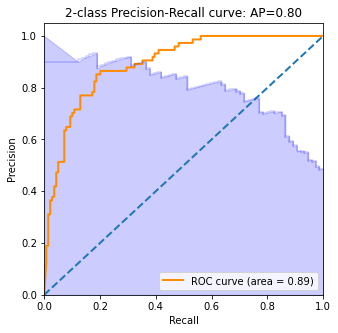

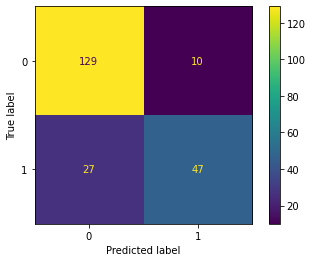

In [222]:
#Discriminant Quadrant
l_param_grid_DQ = {'reg_param': [0.00001, 0.0001, 0.001,0.01, 0.1]} 
l_classifier_DQ = QuadraticDiscriminantAnalysis()
l_optimal_DQ= TestOneClassifier(l_classifier_DQ, X,y, 10, l_param_grid_DQ,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6757, 0.6410, 0.7559
Recall Average : 0.6725
Precision Average : 0.6412
Score Averag : 0.7619
F1-Score Averag : 0.6543


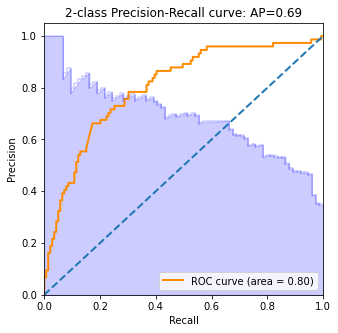

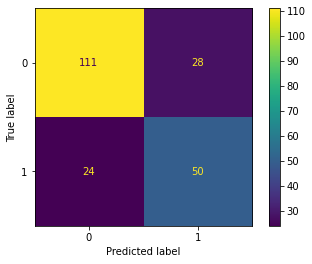

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7973, 0.7973, 0.8592
Recall Average : 0.7427
Precision Average : 0.7369
Score Averag : 0.8203
F1-Score Averag : 0.7348


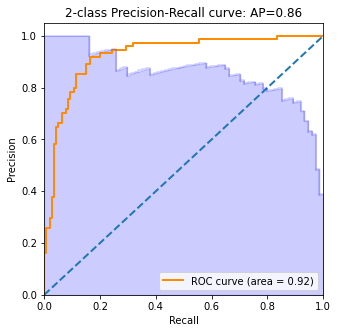

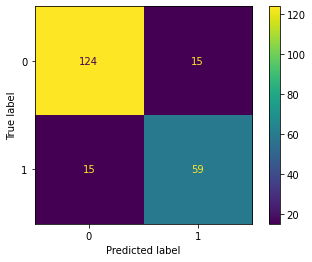

In [353]:
#Neural network
l_param_gridMLP = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  
    'alpha': [0.000001, 0.00001, 0.0001],
    'solver': ['lbfgs', 'sgd', 'adam']}
l_hidden_layers = (10,120,10)
#l_hidden_layers = (35,70,2)
l_MLPbasic = MLPClassifier(hidden_layer_sizes=l_hidden_layers, batch_size='auto', warm_start=True, max_iter=400)
l_optimal_MLP= TestOneClassifier(l_MLPbasic, X,y, 10, l_param_gridMLP,  True, True)

In [354]:
l_optimal_MLP.get_params()

{'activation': 'logistic',
 'alpha': 1e-06,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (10, 120, 10),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 400,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': True}

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.6622, 0.7424, 0.8028
Recall Average : 0.6925
Precision Average : 0.7251
Score Averag : 0.8081
F1-Score Averag : 0.7062


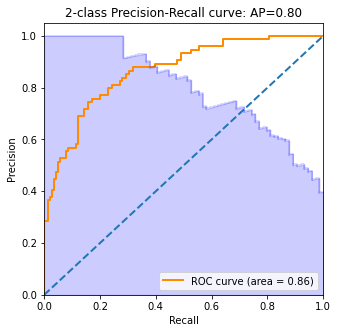

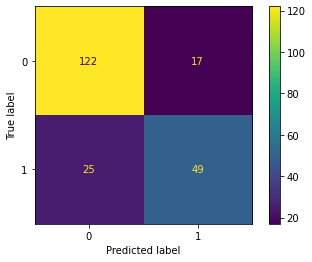

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7838, 0.8406, 0.8732
Recall Average : 0.7004
Precision Average : 0.7294
Score Averag : 0.8071
F1-Score Averag : 0.7105


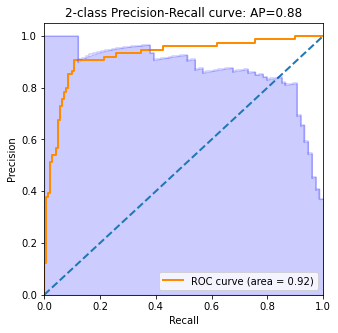

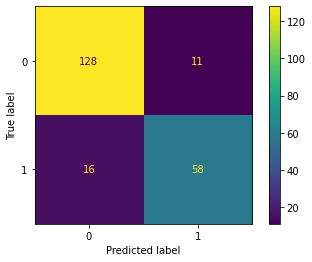

In [352]:
#Neural network, solver='sgd'
l_param_gridMLPsgd = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  
    'alpha': [0.000001, 0.00001, 0.0001],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'momentum': [0.1,0.5,0.9]}
l_hidden_layers = (35,70,2) #10/120/10
l_MLPsgd = MLPClassifier(hidden_layer_sizes=l_hidden_layers, batch_size='auto', warm_start=True, max_iter=400,solver='sgd' )
l_optimal_MLPsgd= TestOneClassifier(l_MLPsgd, X,y, 10, l_param_gridMLPsgd,  True, True)

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.5676, 0.8077, 0.8028
Recall Average : 0.6750
Precision Average : 0.6889
Score Averag : 0.7864
F1-Score Averag : 0.6802


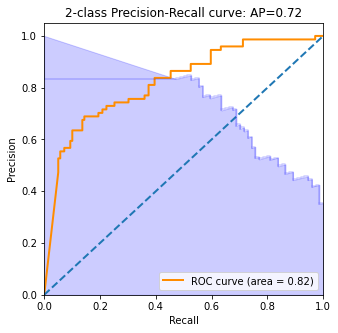

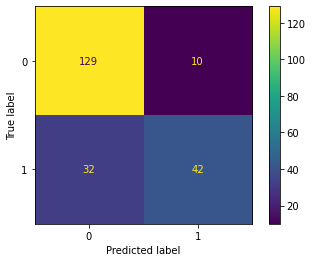

Score sur l'échantillon témoin du classifier
First pass Recall / Precision / Accuracy : 0.7838, 1.0000, 0.9249
Recall Average : 0.5675
Precision Average : 0.5399
Score Averag : 0.7252
F1-Score Averag : 0.5308


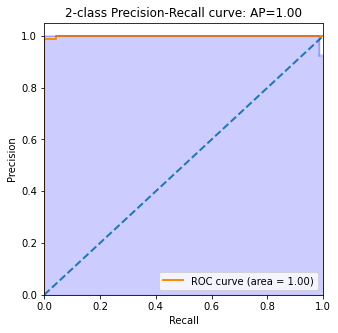

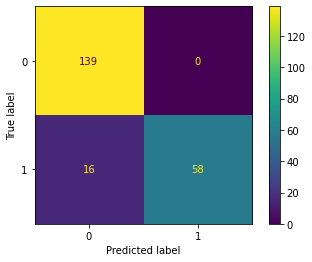

In [355]:
#Neural network, solver='adam'
l_param_gridMLPadam = {
         'activation': ['identity', 'logistic', 'tanh', 'relu'],  
        'alpha': [0.000001, 0.00001, 0.0001],
        'beta_1': [0.1,0.5,0.9],
        'beta_2': [0.1,0.5,0.999],
        'n_iter_no_change': [10,20,30]}
l_hidden_layers = (35,70,2)
l_MLPadam = MLPClassifier(hidden_layer_sizes=l_hidden_layers, batch_size='auto', warm_start=True, max_iter=500,solver='adam' )
l_optimal_MLPadam= TestOneClassifier(l_MLPadam, X,y, 10, l_param_gridMLPadam,  True, True)

In [293]:
def AggregateModels(p_listofclassifiers, p_X, p_y, p_seed=0, p_probathreshold = 0.8, p_graphit = True):
    if (p_seed==0):
        l_seed = random.randint(0,1000)
    else:
        l_seed = p_seed
    X_train, X_test, y_train, y_test = train_test_split(p_X, p_y, test_size=200, random_state=l_seed)
    l_listofpredictions = []
    l_listofproba=[]
    for l_classifier in p_listofclassifiers:
        l_classifier.fit(X_train, y_train)
        l_youtput = l_classifier.predict(X_test)
        l_yproba = pd.DataFrame(l_classifier.predict_proba(X_test))[0]
        l_listofpredictions.append(l_youtput)
        l_listofproba.append(l_yproba)
    l_alloutput = pd.DataFrame(l_listofpredictions)
    l_allproba = pd.DataFrame(l_listofproba)
    l_alloutput = l_alloutput.T
    l_allproba = l_allproba.T
    
    #based on results
    l_unanimitytarget = len(p_listofclassifiers)
    l_majoritytarget = l_unanimitytarget / 2
    l_player = l_alloutput.copy()
    l_player['sum']= l_player.sum(axis=1)
    l_player['unanime'] = l_player['sum'].apply(lambda x: 1 if x==l_unanimitytarget else 0)
    l_player['majority'] = l_player['sum'].apply(lambda x: 1 if x> l_majoritytarget else 0)
    l_player['oneatleast'] = l_player['sum'].apply(lambda x: 1 if x> 0 else 0)
    l_ysimplepredict = l_player.unanime
    l_ysimplemajority = l_player.majority
    l_oneatleast = l_player['oneatleast']
    
    #based on proba
    l_probatarget = p_probathreshold * (l_unanimitytarget-1)
    l_playerproba = l_allproba.copy()
    l_playerproba['sum']= 3 - l_playerproba.sum(axis=1)
    l_playerproba['mean']= 1- l_playerproba.mean(axis=1)
    l_playerproba['threshold'] = l_playerproba['sum'].apply(lambda x: 1 if x>l_probatarget else 0)
    l_probalimit = l_playerproba['threshold']
    #l_playerproba['majority'] = l_playerproba['sum'].apply(lambda x: 1 if x> l_majoritytarget else 0)
    #l_playerproba['oneatleast'] = l_playerproba['sum'].apply(lambda x: 1 if x> 0 else 0)
    
    l_ycompared =l_probalimit
    l_simplecm = confusion_matrix(y_test, l_ycompared)
    l_score = accuracy_score(y_test, l_ycompared)
    l_precision = precision_score(y_test, l_ycompared)
    l_recall = recall_score(y_test, l_ycompared)
    l_f1score = f1_score(y_test, l_ycompared)
    l_bas = balanced_accuracy_score(y_test, l_ycompared)
    
    #Graphe
    if (p_graphit):
        print(f"Recall : {l_recall*100:.0f}%, Precision : {l_precision*100:.0f}%, Score : {l_score*100:.0f}%, F1 Score : {l_F1score*100:.0f}% et Balancy Accuracy : : {l_bas*100:.0f}%")
        # ROC curve
        y_pred = [1-x for x in l_playerproba['mean']]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        plt.figure(1, figsize = (5, 5))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        #plt.show()
        # PR curve
        average_precision = average_precision_score(y_test, y_pred)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        plt.figure(1, figsize = (5, 5))
        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.show()
        ConfusionMatrixDisplay(confusion_matrix=l_simplecm).plot()
        
    return(l_recall, l_precision, l_score, l_f1score, l_bas, l_ycompared, l_playerproba)

In [284]:
l_bestrandomforest = RandomForestClassifier(max_depth = None, min_samples_split = 10, 
                                            n_estimators = 200, n_jobs = -1, random_state = 25)
l_bestbagging = BaggingClassifier(n_estimators=100, random_state = 25)
l_bestgradient = GradientBoostingClassifier( learning_rate = 0.1, max_depth = 3, n_estimators = 100, 
                                            random_state = 25, subsample = 0.5)
l_selectedclassifiers = [l_bestrandomforest, l_bestbagging, l_bestgradient]
l_recallaverage = 0
l_boucle = 20
l_allrecalls = []
l_allprecision = []
l_allscores = []
l_f1scores = []
l_basscores = []
for l_random in range(1,l_boucle+1):
    l_resultmodels = AggregateModels(l_selectedclassifiers, X, y, l_random, 0.5, False)
    l_thisrecall = l_resultmodels[0]  
    l_thisprecision = l_resultmodels[1]
    l_thisscore = l_resultmodels[2]
    l_thisF1score = l_resultmodels[3]
    l_thisbasscore = l_resultmodels[4]
    l_recallaverage += l_thisrecall
    l_allrecalls.append(l_thisrecall)
    l_allprecision.append(l_thisprecision)
    l_allscores.append(l_thisscore)
    l_f1scores.append(l_thisF1score)
    l_basscores.append(l_thisbasscore)
print(f"Recall moyen sur {l_boucle} boucles : {100*l_recallaverage/l_boucle:.2f}%")

Recall moyen sur 20 boucles : 92.38%


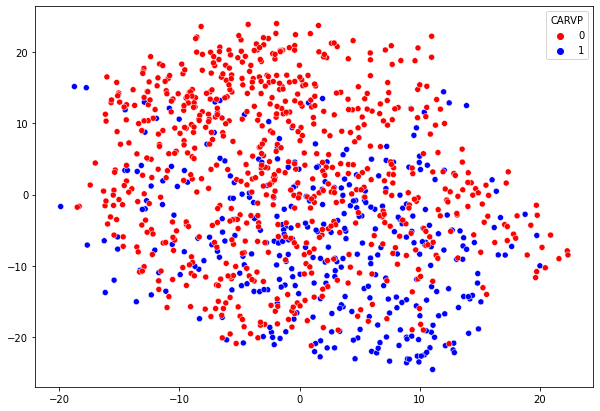

In [13]:
#projection TSNE de X, y
l_tsne = TSNE(n_components=3, random_state = 25)
l_Xrawtsne = l_tsne.fit_transform(X)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=l_Xrawtsne[:,0], y=l_Xrawtsne[:,1],
              data=l_Xrawtsne, hue=y,
              palette=['red','blue'],
              legend='full')
plt.show()

In [14]:
l_oversampler = SMOTE()
X_resampled, y_resampled = l_oversampler.fit_resample(X, y)

In [15]:
#projection TCNE
l_tsne = TSNE(n_components=3, random_state = 25)
l_Xtsne = l_tsne.fit_transform(X_resampled)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=l_Xtsne[:,0], y=l_Xtsne[:,1],
              data=l_Xtsne, hue=y_resampled,
              palette=['red','blue'],
              legend='full')
plt.show()

In [18]:
#Resampling : Over-sampling, under-sampling


def AggregateModelsOnBalanced(p_listofclassifiers, p_X, p_y, p_seed=0, 
                              p_probathreshold = 0.8, p_graphit = True,
                              p_type = 0, p_aggregmethod = 0):
    if (p_seed==0):
        l_seed = random.randint(0,1000)
    else:
        l_seed = p_seed
    random.seed(l_seed)
    X_train, X_test, y_train, y_test = train_test_split(p_X, p_y, 
                                                        test_size=200, random_state=l_seed)
    
    if (p_type == 0):
        Xtouse = X_train
        Ytouse = y_train
    else:
        if (p_type == 1):
            l_oversampler = SMOTE(random_state = l_seed)
            X_resampled, y_resampled = l_oversampler.fit_resample(X_train, y_train)
            Xtouse = X_resampled
            Ytouse = y_resampled
        else:      
            l_undersample = NearMiss(version=3, n_neighbors_ver3=3)
            X_undersampled, y_undersampled = l_undersample.fit_resample(X_train, y_train)
            Xtouse = X_undersampled
            Ytouse = y_undersampled

    l_listofpredictions = []
    l_listofproba=[]
    for l_classifier in p_listofclassifiers:
        l_classifier.fit(Xtouse, Ytouse)
        l_youtput = l_classifier.predict(X_test)
        l_yproba = pd.DataFrame(l_classifier.predict_proba(X_test))[0]
        l_listofpredictions.append(l_youtput)
        l_listofproba.append(l_yproba)
    l_alloutput = pd.DataFrame(l_listofpredictions)
    l_allproba = pd.DataFrame(l_listofproba)
    l_alloutput = l_alloutput.T
    l_allproba = l_allproba.T
    
    #based on results
    l_unanimitytarget = len(p_listofclassifiers)
    l_majoritytarget = l_unanimitytarget / 2
    l_player = l_alloutput.copy()
    l_player['sum']= l_player.sum(axis=1)
    l_player['unanime'] = l_player['sum'].apply(lambda x: 1 if x==l_unanimitytarget else 0)
    l_player['majority'] = l_player['sum'].apply(lambda x: 1 if x> l_majoritytarget else 0)
    l_player['oneatleast'] = l_player['sum'].apply(lambda x: 1 if x> 0 else 0)
    l_ysimplepredict = l_player.unanime
    l_ysimplemajority = l_player.majority
    l_oneatleast = l_player['oneatleast']
    
    #based on proba
    l_probatarget = p_probathreshold * (l_unanimitytarget-1)
    l_playerproba = l_allproba.copy()
    l_playerproba['sum']= 3 - l_playerproba.sum(axis=1)
    l_playerproba['mean']= 1- l_playerproba.mean(axis=1)
    l_playerproba['threshold'] = l_playerproba['sum'].apply(lambda x: 1 if x>l_probatarget else 0)
    l_probalimit = l_playerproba['threshold']
    #l_playerproba['majority'] = l_playerproba['sum'].apply(lambda x: 1 if x> l_majoritytarget else 0)
    #l_playerproba['oneatleast'] = l_playerproba['sum'].apply(lambda x: 1 if x> 0 else 0)
    
    if (p_aggregmethod == 0):
        l_ycompared =l_oneatleast
    else:
        l_ycompared =l_probalimit
        
    l_simplecm = confusion_matrix(y_test, l_ycompared)
    l_score = accuracy_score(y_test, l_ycompared)
    l_precision = precision_score(y_test, l_ycompared)
    l_recall = recall_score(y_test, l_ycompared)
    l_f1score = f1_score(y_test, l_ycompared)
    l_bas = balanced_accuracy_score(y_test, l_ycompared)
    
    #Graphe
    if (p_graphit):
        print(f"Recall : {l_recall*100:.0f}%, Precision : {l_precision*100:.0f}%, Score : {l_score*100:.0f}%, F1 Score : {l_F1score*100:.0f}% et Balancy Accuracy : : {l_bas*100:.0f}%")
        # ROC curve
        y_pred = [1-x for x in l_playerproba['mean']]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        plt.figure(1, figsize = (5, 5))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        #plt.show()
        # PR curve
        average_precision = average_precision_score(y_test, y_pred)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        plt.figure(1, figsize = (5, 5))
        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.show()
        ConfusionMatrixDisplay(confusion_matrix=l_simplecm).plot()
        
    return(l_recall, l_precision, l_score, l_f1score, l_bas, l_ycompared, l_playerproba)

In [19]:
l_bestrandomforest = RandomForestClassifier(max_depth = None, min_samples_split = 10, 
                                            n_estimators = 200, n_jobs = -1, random_state = 25)
l_bestbagging = BaggingClassifier(n_estimators=100, random_state = 25)
l_bestgradient = GradientBoostingClassifier( learning_rate = 0.1, max_depth = 3, n_estimators = 100, 
                                            random_state = 25, subsample = 0.5)
l_selectedclassifiers = [l_bestrandomforest, l_bestbagging, l_bestgradient]
l_recallaverage = 0
l_boucle = 20
l_allrecalls = []
l_allprecision = []
l_allscores = []
l_f1scores = []
l_basscores = []
for l_random in range(1,l_boucle+1):
    l_resultmodels = AggregateModelsOnBalanced(l_selectedclassifiers, X, y, 
                                               l_random, 0.5, False,1,1)
    l_thisrecall = l_resultmodels[0]  
    l_thisprecision = l_resultmodels[1]
    l_thisscore = l_resultmodels[2]
    l_thisF1score = l_resultmodels[3]
    l_thisbasscore = l_resultmodels[4]
    l_recallaverage += l_thisrecall
    l_allrecalls.append(l_thisrecall)
    l_allprecision.append(l_thisprecision)
    l_allscores.append(l_thisscore)
    l_f1scores.append(l_thisF1score)
    l_basscores.append(l_thisbasscore)
print(f"Recall moyen sur {l_boucle} boucles : {100*l_recallaverage/l_boucle:.2f}%")

Recall moyen sur 20 boucles : 94.75%


In [20]:
np.mean(l_allprecision)

0.7862212743087759

In [21]:
np.mean(l_f1scores)

0.8586925004351397

In [22]:
np.mean(l_allscores)

0.8960000000000001

In [23]:
np.mean(l_basscores)

0.9088559919340687

In [ ]:
plt.figure(figsize=(50,50))
tree.plot_tree(l_optimal_DT)
plt.show